# Numerical Methods for Bayesian Inference
## Glaciology and Machine Learning Summer School - Doug Brinkerhoff

In our exploration of optimization and automatic differentiation, we already saw how we might use tools like pytorch to facilitate the solution of inverse problems like inferring the ice hardness parameter $A$ (or its logarithm) from observations of surface velocity.  That problem was well-posed in the sense that there was a bijection between $A$ and $u_{obs}$ - one uniquely specifies the other and vice versa.  However, this is a significant oversimplification of glaciological reality.  In practice, it is often the case that multiple intertangled factors lead to the signals that we observe - for example, we all know that not only does deformation play a role in glacier motion, but sliding does as well, and the friction coefficient $\beta$ (or its logarithm, which we will refer to here as $\gamma$) is similarly unconstrained.  A solution for the SIA with sliding is
$$
u(z) = -\left[\frac{A}{2} (\rho g)^n \left|\frac{\partial S}{\partial x}\right|^{n-1} \bigg(H^{n+1} - (S-z)^{n+1}\bigg) \frac{\partial S}{\partial x} + \frac{\rho g H}{\beta} \frac{\partial S}{\partial x}\right],
$$

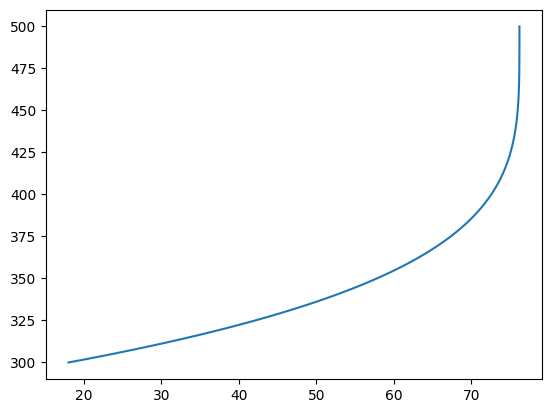

In [2]:
import torch
torch.set_default_dtype(torch.float64)
import numpy as np
import matplotlib.pyplot as plt

A = 1e-16
dSdx = -0.1
H = 200
rho = 917
g = 9.81
n = 3.0
beta = 1e4

S = 500
z = torch.linspace(S-H,S,101)

params = [H,S,dSdx,rho,g,n]

def u_sia(z,A,beta,H,S,dSdx,rho,g,n):
    return -(0.5*A*(rho*g)**n*abs(dSdx)**(n-1)*(H**(n+1) - (S-z)**(n+1))*dSdx + rho*g*H*dSdx/beta)

u_pred = u_sia(z,A,beta,*params)

plt.plot(u_pred,z)

Note that the velocity at the bottom is no longer zero.  Note also that for this model to make sense, $A$ needs to be non-negative and $\beta$ need to be strictly positive.

As before, let's assume that we also have a few observations.

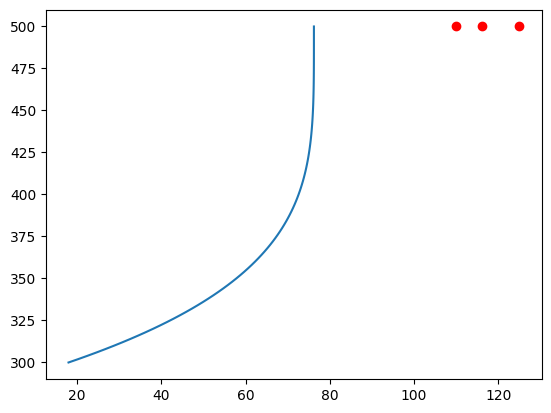

In [3]:
# Observations
u_obs = torch.tensor([116.,110., 125.])
sigma_obs = torch.tensor([10])

plt.plot(u_pred,z)
plt.plot(u_obs,S*np.ones_like(u_obs),'ro')

Is it possible to learn something about both of these parameters simultaneously?  Can we distinguish between the case where the ice is deforming slowly and sliding fast versus when its deforming fast and sliding slowly?  Of course the answer is no, not without more information.  However, a probabilistic perspective can give us insight into the distribution of plausible parameter combinations that can explain the data.   

### Bayes Theorem
As we have seen, Bayes' theorem provides a mechanism for quantifying the knowledge about unobserved variables from observed ones.  In this case we have
$$
P(\alpha,\gamma | u_{obs}) = \frac{P(u_{obs} | \alpha, \gamma) P(\alpha) P(\gamma)}{P(u_{obs})}.
$$
To use Bayes theorem, we have to specify likelihood and prior models.  For a likelihood model, we will assume that the observations are normally distributed around the true value (which we assume is what the model will predict when given correct parameter values) with known standard deviation
$$
P(u_{obs} | \alpha,\gamma) = \mathcal{N}(u_{sia}(\alpha,\gamma,\ldots), \sigma_{obs}).
$$
If we have replicate observations, then we assume that observations are independent and identically distributed
$$
P(\mathbf{u}_{obs} | \alpha,\gamma) = \prod_{i=1}^{n_{obs}} P(u_{obs,i} | \alpha,\gamma).
$$
Next we need a prior distribution over the parameters.  Here we will assume that *a priori* both parameters are normally distributed around an assumed mean with an assumed standard deviation.
$$
P(\gamma) = \mathcal{N}(\gamma_0, \sigma_\gamma),
$$
$$
P(\alpha) = \mathcal{N}(\alpha_0, \sigma_\alpha).
$$
As always, picking a prior is a bit of an art and subjective process.  Here, I will assume that a reasonable guess for $\alpha$ is the log of $10^{-16}$ and that a reasonable standard deviation is unity (we can adjust these assumptions later).  Similarly, a reasonable prior for the traction would be some fraction of the (log of the) driving stress, with similar standard deviation.   

We can encode all of these assumptions in several functions.  Obviously, we will be using normal distributions, so let's write a function that evaluates the probability density of a normal distribution.  Note that for both numerical and algebraic reasons, it is often preferable to work with the logarithm of a probability density function.

In [4]:
def log_normal_diagonal(x,mu,sigma):
    k = mu.shape[-1]
    return -k/2.*np.log(2*np.pi) - 0.5*torch.log(sigma**2).sum() - 0.5*(((x-mu)/sigma)**2).sum(axis=-1)

This method is batched - it is written so as to be evaluated for multiple samples, which will be useful later.  

It will be helpful to encapsulate methods for evaluating the prior and likelihood into a class

In [9]:
class SIAPosterior:
    def __init__(self,z_obs,u_obs,sigma_obs,mu_prior,sigma_prior,params):
        self.z_obs = z_obs
        self.u_obs = u_obs
        self.sigma_obs = sigma_obs

        self.mu_prior = mu_prior
        self.sigma_prior = sigma_prior

        self.params = params

    def log_prior(self,m):
        return log_normal_diagonal(m,self.mu_prior,self.sigma_prior)

    def log_likelihood(self,m):
        u_pred = u_sia(self.z_obs,*torch.exp(m).T,*self.params).reshape(-1,1)
        return log_normal_diagonal(self.u_obs,u_pred,self.sigma_obs)

    def log_posterior(self,m):
        return self.log_prior(m) + self.log_likelihood(m)

# Initial guesses
alpha = torch.tensor(np.log(1e-16))
gamma = torch.tensor(np.log(1e4))

m = torch.tensor([alpha,gamma])

# Prior mean and standard deviation
mu_prior = torch.tensor((alpha,gamma))
sigma_prior = torch.tensor((1,1.))

sia = SIAPosterior(S,u_obs,sigma_obs,mu_prior,sigma_prior,params)
print('log-prior: ',sia.log_prior(m))
print('log-likelihood: ',sia.log_likelihood(m))


log-prior:  tensor(-1.8379)
log-likelihood:  tensor([-28.7252])


Now we've almost got all the things we need to use Bayes' theorem - the one remaining term is the denominator (sometimes called the "evidence").  However this turns out to be the hard one.  Writing this term as
$$
P(\mathbf{u}_{obs}) = \int P(\mathbf{u}_{obs}|\alpha,\gamma) P(\alpha,\gamma) \; \mathrm{d}\alpha \;\mathrm{d}\gamma.
$$
Note the integral over *all possible parameter combinations*!  This turns out to be intractable to evaluate for most problems, particularly when either the distributions involved are non-Gaussians *or* the parameter-to-observable map is non-linear.  While we satisfy the first, our model is clearly non-linear.  As such, there is no closed form for the left-hand side of Bayes Theorem.  What to do?  

### Numerical Approximations
One obvious thing that we have already spent quite a bit of time doing is to find the most probable solution.  Because the denominator is a constant with respect to the model's parameters, it does not influence the location of the minimum.  This corresponds to the same regularized optimization problem that we've seen before.

Text(0, 0.5, 'z (m)')

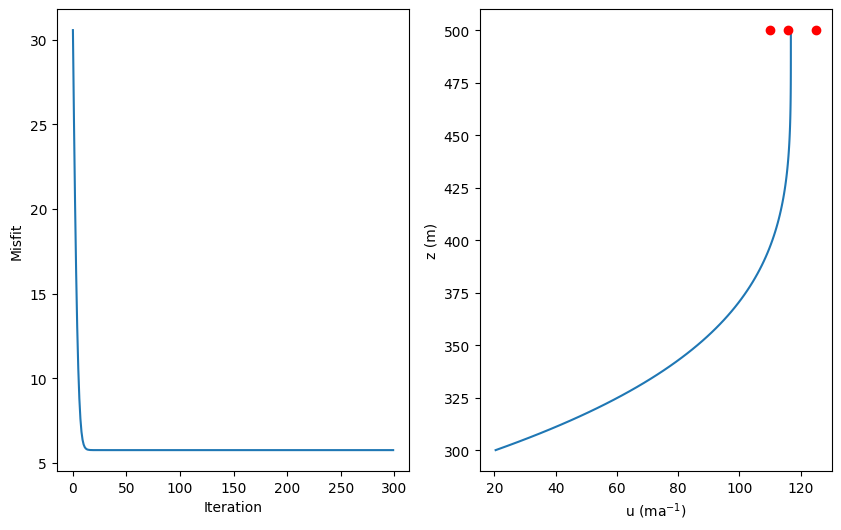

In [10]:
m = torch.tensor((alpha,gamma),requires_grad=True)

optimizer = torch.optim.SGD([m],lr=1e-3)

n_iters = 300

L_vals = []
u_vals = []
for i in range(n_iters):
    optimizer.zero_grad()
    L = -(sia.log_likelihood(m) + sia.log_prior(m))
    L_vals.append(L.detach())
    u_vals.append(u_pred.detach())
    L.backward()
    optimizer.step()

fig,axs = plt.subplots(ncols=2)
fig.set_size_inches(10,6)
axs[0].plot(L_vals)
axs[0].set_xlabel('Iteration')
axs[0].set_ylabel('Misfit')

u_pred = u_sia(z,*torch.exp(m.detach()),*params)
axs[1].plot(u_pred,z)
axs[1].plot(u_obs,S*np.ones_like(u_obs),'ro')
axs[1].set_xlabel('u (ma$^{-1}$)')
axs[1].set_ylabel('z (m)')

This produces *a* solution that matches the data - but we expect that there could be others, and as good scientists we want to know about all the possible situations that explain the data.  Achieving this goal is tantamount to a full characterization of the posterior distribution, which can be approximated in several ways.  Here we focus on three different methods that have been used with some success in glaciology.  Each takes a rather different approach and as a result each method will have different strengths and shortcomings.  

### Markov Chain Monte Carlo sampling
When performing analysis of observational data that has many samples, one of the first things that most of us will do is to plot a histogram, which provides a (discretized) picture of a distribution's probability density function.  Note that this makes no assumptions about any parametric form or really anything else - samples themselves contain all the information needed to characterize the distribution from which they were drawn, no matter how strange it may be.  The big caveat here is that you have to have enough samples to construct a reasonably detailed histogram.  As such, one way to characterize the probability density function of a posterior distribution is to draw a large number of samples from it.  This is precisely what Markov Chain Monte Carlo (MCMC) sampling is designed to do.  

The prototypical MCMC algorithm is called the Metropolis algorithm.  It is called Markov Chain Monte Carlo, because its randomized (hence the Monte Carlo), and because we create a new sample by making a small perturbation to an existing existing sample and then another small perturbation to that one and so on, a process which generates a Markov Chain.  While there are many sophisticated variants to this idea, the basic Metropolis algorithm is extremely simple.

We begin with some random value for the parameters that we seek to infer the distribution of.  Common choices include the prior mean or the most probable value as found previously.  Next, we generate a new candidate sample by perturbing the current parameter value according to a so-called proposal distribution, which is often just a unit Gaussian with specified standard deviation $h$ (this proposal step size is a tuneable parameter and can be modified to improve the convergence of the algorithm.  More complex proposals that utilize gradient information, inferred correlations, etc. are the basis for much of the richness of MCMC research).  Next, we evaluate the unscaled log-posterior at both the proposed and current locations.  If the proposed parameter value is more probable than the current ones, then we accept the proposal.  If it is less probable, then we accept with probability proportional to the ratio between the proposed and current proabilities.  We then repeat this process many times, saving the result of the sampling at each step in the algorithm.  It turns out that the values stored in the chain are samples from the posterior distribution. Let's see how this works in python.  

In [11]:
class Metropolis:
    def __init__(self):
        # Initialize chains
        self.P_chain = []
        self.m_chain = []

    def sample(self,m_0,log_posterior,h,n_samples,burnin=0,thin_factor=1):
        # Compute initial unscaled log-posterior
        P_0 = log_posterior(m_0)

        n = len(m_0)

        # Draw samples
        for i in range(n_samples):

            # Propose new value according to
            # proposal distribution Q(m) = N(m_0,h)
            m_prime = m_0 + torch.randn(n)*h

            # Compute new unscaled log-posterior
            P_1 = log_posterior(m_prime)

            # Compute logarithm of probability ratio
            log_ratio = P_1 - P_0

            # Convert to non-log space
            ratio = torch.exp(log_ratio)

            # If proposed value is more probable than current value, accept.
            # If not, then accept proportional to the probability ratios
            if ratio>torch.rand(1):
                m_0 = m_prime
                P_0 = P_1

            # Only append to the chain if we're past burn-in.
            if i>burnin:
                # Only append every j-th sample to the chain
                if i%thin_factor==0:
                    self.P_chain.append(P_0)
                    self.m_chain.append(m_0)

        return torch.tensor(self.P_chain),torch.vstack(self.m_chain)

That's it.  Let's use MCMC to draw some samples.  Note that we use a helper function that evaluates the sum of the log-likelihood and the log-prior.  I've called this function "log_posterior" but it's important to understand that this is only true up to a constant!

In [12]:
# Instantiate sampler
sampler = Metropolis()

# Draw samples
P_chain,m_chain = sampler.sample(m_0,sia.log_posterior,0.1,20000,burnin=1000)

Having taken just a moment to draw 20000 samples (we have a pretty fast model to evaluate), we can now plot the results

Text(0, 0.5, 'gamma')

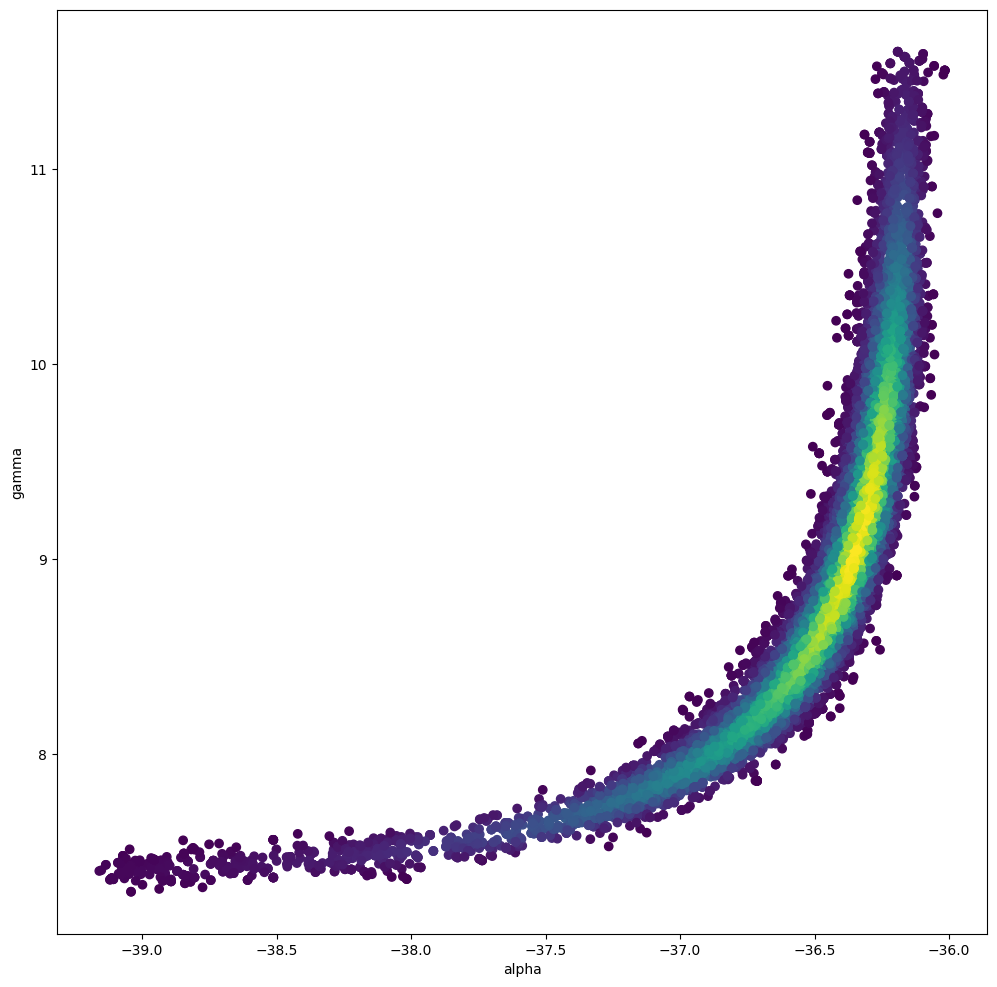

In [13]:
fig,ax = plt.subplots()
fig.set_size_inches(12,12)
ax.scatter(*m_chain.T,c=torch.exp(P_chain))
ax.set_xlabel('alpha')
ax.set_ylabel('gamma')

This banana-looking shape makes sense for the current model.  Note that MCMC only converges to the true distribution in the limit as the number of samples goes to infinity and it can be a significant challenge to know whether we have drawn enough samples.  This is a **significant weakness** of this method.  One heuristic for evaluating convergence is to look at the history of samples as a function of time.  They should traverse the probable space many times (so-called "good mixing").

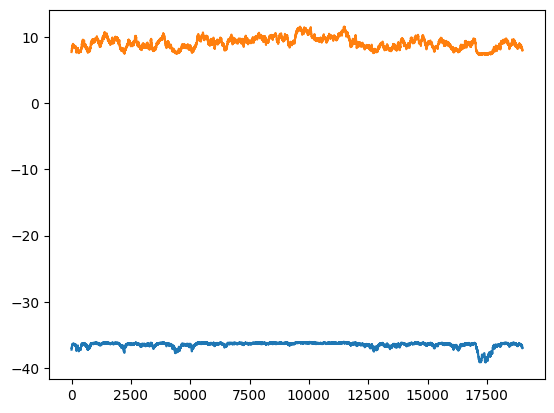

In [14]:
plt.plot(m_chain)

These ones look okay - not great.  We should pro/bably run the sampler for longer - however this can be a big problem when the model is expensive to run and the parameter space is larger than this one.  Further more MCMC is not easily parallelized.  In summary, MCMC is by far the best method for characterizing complex distributions because it requires the fewest assumptions on posterior form.  However, it is difficult to scale to large problems.  Finally, it is educational to look at the posterior predictive distribution over velocties

Text(0, 0.5, 'z (m)')

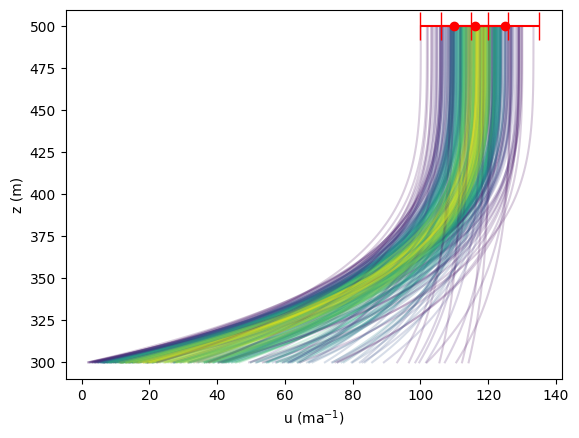

In [15]:
P_max = torch.exp(P_chain.max())
for m,p in zip(m_chain[1::50],torch.exp(P_chain[1::50])):
    c = plt.cm.viridis(p/P_max)
    u_pred = u_sia(z,*torch.exp(m),*params)
    plt.plot(u_pred,z,color=c,alpha=0.2)

plt.errorbar(u_obs,S*np.ones_like(u_obs),xerr=10,fmt='ro',capsize=10)

plt.xlabel('u (ma$^{-1}$)')
plt.ylabel('z (m)')

Note the diversity of solutions!  We have *both* low slip-high deformation solutions and the converse, *and* we have solutions corresponding to the range of assumed error in the velocity measurements.

**CHALLENGE PROBLEM**: Implement the [Metropolis-adjusted Langevin algorithm](https://en.wikipedia.org/wiki/Metropolis-adjusted_Langevin_algorithm), which adjusts the proposal distribution (and achieves faster convergence) by biasing the proposal distribution towards regions of high probability using the gradient of the log-likelihood (which is conveniently available via our pytorch implementation).   

### Variational inference
Variational inference (VI) takes a very different approach than MCMC.  Rather than try to characterize the true distribution with samples, VI assumes *a priori* the family of the posterior distribution (for example a Gaussian, or Gamma, or whatever parametric distribution seems to be sensible) and seeks to find the parameters of that approximating distribution that make it match as closely as possible to the true distribution according to some metric.  By doing this, we can cast the full Bayesian inference problem as a minimization problem.  

First, let's define our approximating posterior distribution
$$
q_\theta(\mathbf{m}) = \mathcal{N}(\boldsymbol{\mu}_v, \Sigma_v),
$$
$$
\Sigma_v = \text{diag} (\exp \boldsymbol{\rho}_v)
$$
where $\mathbf{m} = [\alpha,\gamma]$.  A few things to unpack here.  The most important assumption is that our posterior distribution is to be approximated by a normal distribution.  This normal distribution will have a (learnable) mean $\boldsymbol{\mu}_v$ and a (learnable) covariance matrix $\Sigma_v$.  Next, we will also impose some additional structure on this posterior covariance matrix, namely that it is diagonal - this is a rather significant assumption where we assume that *a posteriori* the parameters will be uncorrelated.  Of course we know from looking at the results of MCMC that this is not true.  However, one of the strengths of VI is that it allows us to impose structural assumptions for the sake of numerical tractability - because we assume the matrix is diagonal, it can be characterized with only $n$ numbers, rather than the $\frac{n (n+1)}{2}$ required to fill in a full covariance matrix.  We also must ensure that the standard deviations are positive, and so we use the same exponential trick as previously and define $\boldsymbol{\rho}_v$ as the logarithms of the posterior standard deviations.  Taken together $\theta=[\boldsymbol{\mu}_v,\boldsymbol{\rho}_v]$ are *variational* parameters, and these are what we will be inferring.  

We seek to adjust $\theta$ such that $q_\theta(\mathbf{m})$ is somehow close to the posterior distribution $P(\mathbf{m}|u_{obs})$.  There are a variety of metric that can be used to characterize the differences between probability distributions.  For variational inference the typical choice is the Kullback-Leibler divergence
$$
D_{KL}[ q_\theta(\mathbf{m}) || P(\mathbf{m}|u_{obs}) ] = -\int q_\theta(\mathbf{m}) \ln \frac{P(\mathbf{m} | u_{obs})}{q_\theta(\mathbf{m})} \mathrm{d} \mathbf{m}.
$$
Using Bayes' theorem, this can be rewritten as
$$
D_{KL}[ q_\theta(\mathbf{m}) || P(\mathbf{m}|u_{obs}) ] = -\underbrace{\int q_\theta(\mathbf{m}) \ln P(u_{obs}|\mathbf{m})\; \mathrm{d}\mathbf{m}}_{\text{Average Likelihood}} -\underbrace{\int q_\theta(\mathbf{m}) \ln P(\mathbf{m}) \; \mathrm{d}\mathbf{m}}_{\text{Average Prior}} + \underbrace{\int q_\theta(\mathbf{m}) \ln q_\theta(\mathbf{m}) \;\mathrm{d}\mathbf{m}}_{\text{Entropy}} + C.
$$
It is straightforward to interpret each of these terms.  The first two penalize the respective departure - on average - of the approximating distribution from the observations and prior.  The third term seeks to maximize the entropy - to make the distribution as flat as possible.

Unfortunately, the integrals remain intractable, and so these must usually be approximated.  A common choice is to make the Monte Carlo approximation, e.g.
$$
\int q_\theta(\mathbf{m}) \ln P(u_{obs}|\mathbf{m})\; \mathrm{d}\mathbf{m} \approx \frac{1}{n_{samples}} \sum_{i=1}^{n_{samples}} P(u_{obs}|\mathbf{m}_i), \quad \mathbf{m}_i \sim q_\theta(\mathbf{m}).
$$
In words, this means that we draw some random samples of parameters from the variational distribution, compute the log-likelihood for each of these samples, and average them.  The resulting estimator is unbiased.

Despite the appearance of mathematical complexity, this really isn't too bad to implement.  It begins much as before, with an initial guess for parameter values, in this case both the means and standard deviations.

In [16]:
mu = sia.mu_prior.clone().detach().requires_grad_(True)
rho_ = torch.zeros(2,requires_grad=True)
rho_.data[:] = -1.  # Initial guess for posterior standard deviation

Minimization is done via gradient descent, so we need gradients - as such the requires_grad flags for the variational parameters is set.  Next we set up a standard optimization problem.  We will run 1000 iterations of gradient descent, and we will approximate the integrals in the KL-divergence with 10 random samples at each iteration.  Interestingly, a common choice is to take $n_{samples}=1$!  We will use gradient descent, so we create an optimizer object as well.

In [17]:
n_iters = 3000
n_samples = 10

optimizer = torch.optim.SGD([mu,rho_],lr=1e-3)
L_vals = []

Finally we just need to compute the (approximation to the) KL-divergence, and perform the standard gradient descent loop.

In [18]:
for i in range(n_iters):
    optimizer.zero_grad()

    # Generate random samples
    eps = torch.randn(n_samples,2)     # Draw random Gaussian noise
    sigma = torch.exp(rho_)            # Compute the standard deviations
    m_samples = mu + sigma * eps       # Scale the noise and add it to the mean

    # Compute the various terms
    avg_log_likelihood = sia.log_likelihood(m_samples).mean()     # Expectation over q of the likelihood
    avg_log_prior = sia.log_prior(m_samples).mean()               # Expectation over q of the prior
    entropy = -log_normal_diagonal(m_samples,mu,sigma).mean()     # Expectation over q of q

    L = -avg_log_likelihood - avg_log_prior - entropy
    L.backward()

    L_vals.append(L.detach())
    optimizer.step()

Let's analyze the values of the cost function through time to see if the method converged:

Text(0, 0.5, 'KL-divergence')

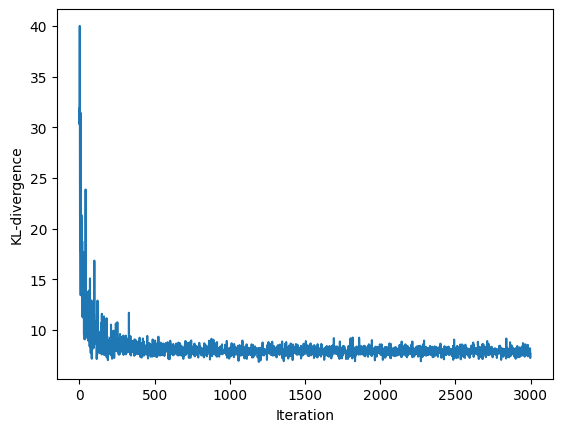

In [19]:
plt.plot(L_vals)
plt.xlabel('Iteration')
plt.ylabel('KL-divergence')

Note that this is a stochastic objective function, so it is difficult to utilize specific convergence criteria - however the loss on average seems to have quite decreasing.  Now, let's have a look at our distribution alongside the MCMC samples.

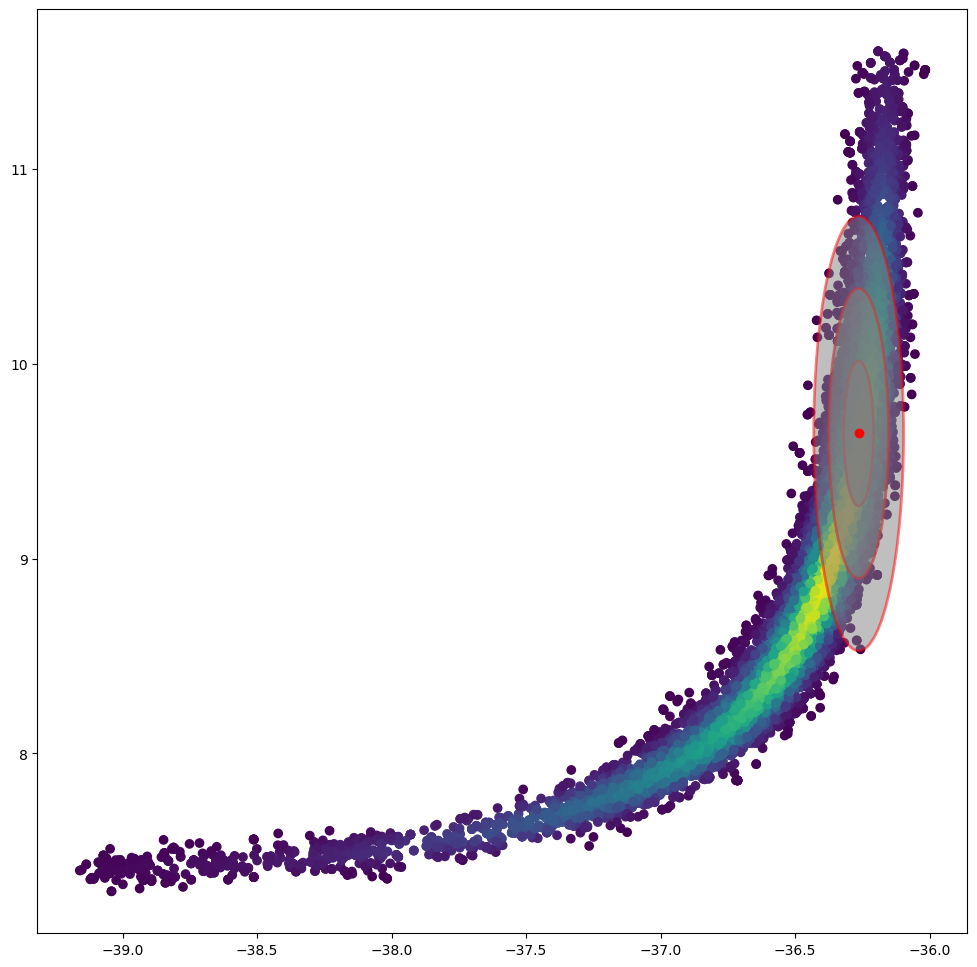

In [20]:
fig,ax = plt.subplots()
fig.set_size_inches(12,12)
ax.scatter(*m_chain.T,c=torch.exp(P_chain))

from matplotlib.patches import Ellipse
for s in range(1,4):
    ell = Ellipse(xy=(mu[0].detach(), mu[1].detach()),
              width=2*s*sigma[0].detach(), height=2*s*sigma[1].detach())
    ell.set_facecolor('gray')
    ell.set_edgecolor('red')
    ell.set_alpha(1 - s/6)
    ell.set_linewidth(2)
    ax.add_artist(ell)
plt.plot(*mu.detach().T,'ro')

A few things to note.  First, we should interpret this distribution as the diagonal Normal that covers the largest amount of probable parameter space (without covering any improbable space).  Because we have assumed no posterior correlations, the approximating distribution cannot "turn the corner".  Presumably, if we used a variational distribution that allowed for off-diagonal terms in the covariance matrix, we could do a better job. Second, the mean of the variational distribution is not necessarily the most probable point!  This is perhaps a good thing - to a Bayesian, the most probable point isn't necessarily any more important than anywhere else in parameter space.

**CHALLENGE PROBLEM**: Redo the above problem with a full (rather than diagonal) covariance matrix.  This isn't that big of a change, but you do have to figure out how to ensure that the covariance is positive definite!

### Laplace Approximation
Finally, we should look at the simplest - but also one of the most useful - methods for posterior approximation.  Laplace's method proceeds by first finding the maximum a posteriori point, which can be done straightforwardly via gradient descent:

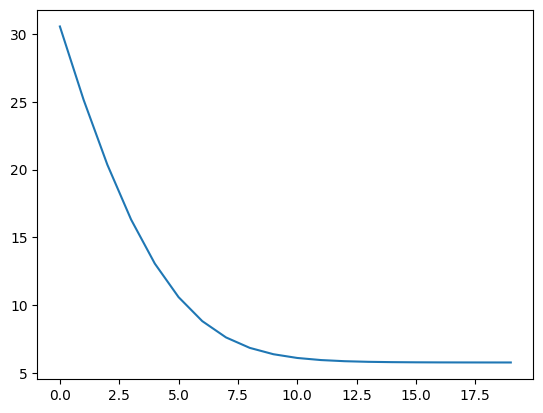

In [21]:
m = sia.mu_prior.clone().detach().requires_grad_(True)

optimizer = torch.optim.SGD([m],lr=1e-3)
n_iters = 20

L_vals = []

for i in range(n_iters):
    optimizer.zero_grad()
    L = -sia.log_posterior(m)
    L.backward()
    #print(L.item())
    optimizer.step()
    L_vals.append(L.detach().item())

plt.plot(L_vals)


Then, we perform a Taylor series expansion of the log-probability to second order around this point.
$$
\mathcal{L}(\mathbf{m} - \mathbf{m}_{MAP}) \approx \mathcal{L}(\mathbf{m}_{MAP}) + \nabla_\mathbf{m}\mathcal{L}(\mathbf{m} - \mathbf{m}_{MAP}) + \frac{1}{2} (\mathbf{m} - \mathbf{m}_{MAP})^T \mathcal{H} (\mathbf{m} - \mathbf{m}_{MAP}),
$$
where $\mathcal{H}$ is the Hessian - the matrix of second derivatives - evaluated at $\mathbf{m}_{MAP}$.  We can immediately make the simplification that the gradient term is zero by virtue of our point being a maximum -
$$
\mathcal{L}(\mathbf{m} - \mathbf{m}_{MAP}) \approx \mathcal{L}(\mathbf{m}_{MAP}) + \frac{1}{2} (\mathbf{m} - \mathbf{m}_{MAP})^T \mathcal{H} (\mathbf{m} - \mathbf{m}_{MAP}).
$$
Exponentiating, we have that
$$
\exp (\mathcal{L}(\mathbf{m} - \mathbf{m}_{MAP})) = P(\mathbf{m}|u_{obs}) \approx Z \exp\left[\frac{1}{2} (\mathbf{m} - \mathbf{m}_{MAP})^T \mathcal{H} (\mathbf{m} - \mathbf{m}_{MAP})\right].
$$
By inspection, we can see that the right hand side looks like a multivariate normal distribution with mean given by $\mathbf{m}_{MAP}$ and covariance matrix given by
$$
\Sigma_{post} = -\mathcal{H}^{-1}.
$$
As such, if we can compute and invert the Hessian of the log-posterior, we can derive an approximation to the posterior distribution.  Note that this approximation is basedon *only* on local curvature information and so may not be accurate away from the most probable point!

Pytorch has a functional model that makes computation of the Hessian straightforward.  However, note that this requires a forward and backwards pass for every column in the Hessian (although there are ways to make this process [more efficient for large scale problems](https://arxiv.org/abs/1410.1221)).   

In [22]:
hess = torch.autograd.functional.hessian(sia.log_posterior,m)
Sigma2 = torch.linalg.inv(-hess)
print(Sigma2)

tensor([[0.0616, 0.2713],
        [0.2713, 1.2700]])


Note the significant off-diagonal component in the posterior covariance!  Let's plot this distribution (as with VI, defined analytically rather than through samples) alongside the other two methods.  

<ipython-input-24-2835635269>:21: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  angle=np.rad2deg(np.arccos(v[0, 0])))


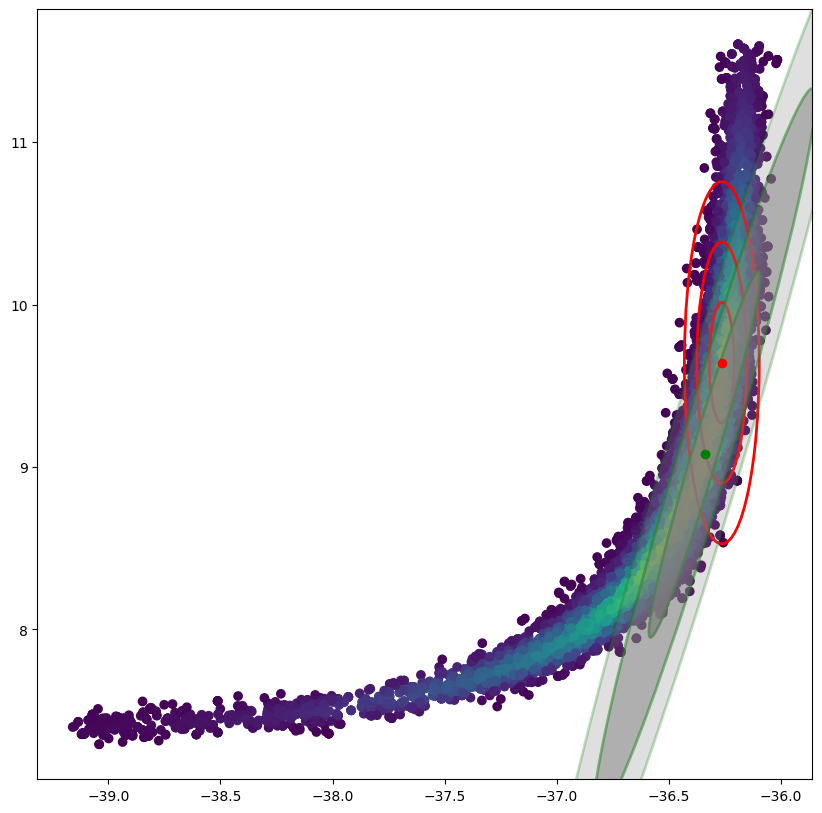

In [24]:
fig,ax = plt.subplots()
fig.set_size_inches(12,12)
ax.scatter(*m_chain.T,c=torch.exp(P_chain))

from matplotlib.patches import Ellipse
for s in range(1,4):
    ell = Ellipse(xy=(mu[0].detach(), mu[1].detach()),
              width=2*s*sigma[0].detach(), height=2*s*sigma[1].detach())
    ell.set_facecolor('none')
    ell.set_edgecolor('red')
    ell.set_alpha(1)
    ell.set_linewidth(2)
    ax.add_artist(ell)
plt.plot(*mu.detach().T,'ro')

lamda,v = torch.linalg.eigh(Sigma2)

for s in range(1, 4):
    ell = Ellipse(xy=(m.detach()[0], m.detach()[1]),
                  width=torch.sqrt(lamda[0])*s*2, height=torch.sqrt(lamda[1])*s*2,
                  angle=np.rad2deg(np.arccos(v[0, 0])))
    ell.set_facecolor('gray')
    ell.set_edgecolor('green')
    ell.set_alpha(1 - s/4)
    ell.set_linewidth(2)
    ax.add_artist(ell)

plt.plot(*m.detach().T,'go')
fig.set_size_inches(10,10)


#plt.scatter(x, y)
plt.show()

Note that the approximation is very good near the MAP point, and gets very bad as the true posterior (or at least the one characterized by MCMC samples) starts to become non-Gaussian (thus violating the assumptions of the method).  This method is extremely useful for posteriors that are approximately Gaussian (even with high correlations), and is especially useful (when implemented in a clever way) when the posterior covariance is approximately low-rank.  It also has some obvious limitations, which the plot above shows nicely.  

**CHALLENGE PROBLEM**: As in [Isaac, 2014](https://arxiv.org/abs/1410.1221), use randomized methods to compute the posterior covariance matrix (i.e. pretend that you cannot form the Hessian directly, and must rely on Hessian-vector products only!).